<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Accuracy assessment of a landcover classification"<br>
    description: "This is a tutorial within the sixth theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2025-04-30<br>
    authors: Andreas Mayr<br>
</details>

# Accuracy assessment of a landcover classification

This Python Notebook demonstrates a procedure for assessing the accuracy of a classification map by comparing a landcover map against a set of manually labelled validation samples. The landcover map has been classified by a Random Forest (trained with a set of labelled points) with a few spectral-temporal metrics as features (see theme 3). The validation samples are points placed by stratified random sampling (predicted landcover as strata) with an equal number of points allocated to each stratum. The main results are:

* a confusion matrix
* a tabular classification report with classification accuracy metrics

To have all required packages installed, we recommend to set up a Conda environment based on the requirements file provided for the course. If you have not yet done this, please see the instructions on the [software page](https://3dgeo-heidelberg.github.io/etrainee/software/software_python.html).

Data:

The course data repository contains a landcover map (`landcover_id.tif`) resulting from the classification workflow shown in theme 3. Either assess your own map or take this one.

Set the directory where data is stored. Save the AOI and the landcover map there.

In [1]:
import pathlib
data_dir = pathlib.Path('C:/work/etrainee/gee/T3') / 'data' # Define path on your local system
data_dir

WindowsPath('C:/work/etrainee/gee/T3/data')

## Accuracy assessment

In this section, we will perform an accuracy assessment based on newly created reference data ('validation data' as it is only used for validation, not for training). We do a stratified random sampling to define points to be labelled manually as reference data. We will simply allocate an equal number of samples in each landcover class. 

The first thing we need is a set of polygons representing the landcover classes to constrain the placement of random points. 

### Vectorize landcover

We vectorize the landcover classes of our classification raster with ```rasterio.features.shapes``` and ```shapely.geometry.shape```. This converts a 2D ```xarray.DataArray``` into a ```geopandas.GeoDataFrame```.

In [3]:
import rioxarray
from rasterio import features
from shapely.geometry import shape
import geopandas as gpd

geometry_list = []
value_list = []

lc_rast = rioxarray.open_rasterio(data_dir / "landcover_id.tif")    # use rioxarray accessor to open GeoTiff as xarray DataArray
for shapedict, value in features.shapes(lc_rast, transform=lc_rast.rio.transform()):    # get a pair of (polygon, value) for each feature found in the image.
    value_list.append(value)
    geometry_list.append(shape(shapedict))  # construct shapely polygons from GeoJSON-like dicts returned by rasterio.features.shapes

lc_dict = {'lc_id': value_list, 'geometry': geometry_list}
lc_gdf = gpd.GeoDataFrame(lc_dict, crs=lc_rast.rio.crs)
lc_gdf['lc_id'] = lc_gdf['lc_id'].astype(int)
lc_gdf

lc_id                                           geometry
0          2  POLYGON ((681940.000 5241670.000, 681940.000 5...
1          3  POLYGON ((682160.000 5241670.000, 682160.000 5...
2          3  POLYGON ((682180.000 5241670.000, 682180.000 5...
3          3  POLYGON ((682620.000 5241670.000, 682620.000 5...
4          3  POLYGON ((683910.000 5241670.000, 683910.000 5...
...      ...                                                ...
16056      1  POLYGON ((688760.000 5237430.000, 688760.000 5...
16057      3  POLYGON ((689470.000 5238730.000, 689470.000 5...
16058      3  POLYGON ((688830.000 5237400.000, 688830.000 5...
16059      3  POLYGON ((689300.000 5237400.000, 689300.000 5...
16060      3  POLYGON ((689480.000 5237570.000, 689480.000 5...

[16061 rows x 2 columns]

### Dissolve landcover polygons

As we want the landcover classes to guide the sampling, the next step is to dissolve the > 10k polygons of our landcover GeoDataFrame by landcover ID (i.e., column 'lc_id') to obtain one multipart polygon for each landcover class.

In [6]:
lc_gdf = lc_gdf.dissolve(by='lc_id', as_index=False)    # Do not use landcover ID as index, keep it as a column

So far, landcover is coded with IDs. For convenience let's add a column with landcover class names as strings.

In [7]:
landcover_dict={1: "Grassland", 2: "Cropland", 3: "Forest", 4: "Water", 5: "Other"}
lc_gdf["Landcover"] = lc_gdf['lc_id'].map(landcover_dict)    # Map values of the new column according to the dictionary
lc_gdf

lc_id                                           geometry  Landcover
0      1  MULTIPOLYGON (((682050.000 5237400.000, 682060...  Grassland
1      2  MULTIPOLYGON (((682030.000 5237400.000, 682040...   Cropland
2      3  MULTIPOLYGON (((682060.000 5237390.000, 682060...     Forest
3      4  MULTIPOLYGON (((681930.000 5237400.000, 681930...      Water
4      5  MULTIPOLYGON (((681950.000 5237390.000, 681950...      Other

### Stratified random sampling

In the next step, we randomly place a fixed number of sample points per landcover class for validation (i.e. *stratified sampling with equal allocation*; for varying numbers of points per class see [here](https://geopandas.org/en/stable/docs/user_guide/sampling.html#Variable-number-of-points)). For simplicity, only 5 samples per class are created but note that more samples are recommended in practice (e.g. 50 samples per class, depending on the complexity of the classification problem). <!--TODO: Create and label more samples.--> We write the samples to disc (as Geopackage).

In [5]:
vali_points = lc_gdf.sample_points(5)                   # Randomly sample a fixed number of validation points in each polygon
vali_points = vali_points.explode(index_parts=False)    # Split mulipart points to single part points
vali_points.to_file(data_dir / "vali_points.gpkg")      # Write validation points to Geopackage

### Manually label sample points in QGIS

The next step is to label the randomly sampled points. We make use of the convenient editing capabilities in QGIS. 

Open QGIS and follow these steps:

* Open the file *vali_points.gpkg* and enable editing for this layer (click the pen symbol).
* Create a new attribute column named 'Reference' with data type *integer* (yellow column symbol in the attribute table or CTRL+W shortcut).
* In the 'Symbology' tab of the 'Layer properties' menu, set colors indicative of the landcover label in the 'Reference' attribute column (helps to see which samples you already labelled).
* Go through the sample points one by one and label them, i.e. as a 'Reference' attribute type the landcover ID you consider appropriate (based on your visual interpretation of the 2019 orthophoto from [this WMS server](https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer)).
* Don't forget to save your edits.

Where did you have problems to clearly identify the true landcover class of a point? Apart from buildings, parking lots and roads, which other situations did not fit well into one of the first four defined target classes?

<center>
<img src="media/qgis_labelling_points.PNG" title="Labelling points in QGIS" width="800">

*Labelling points in QGIS. The point displayed in magenta has not yet been labelled (background: orthophoto 2019 WMS layer, provided by the Department of Geoinformation, Office of the Tyrolean State Government).*
</center>

### Accuracy assessment

#### Assign predicted landcover to sample points

We continue in Python again and load the labelled sample points as GeoDataFrame, then add the predicted landcover IDs at the sample locations.

In [4]:
vali_points = gpd.read_file(data_dir / "vali_points.gpkg")          # Read Geopackage with validation points
vali_points = vali_points.sjoin(lc_gdf, how='inner')                # Spatial join of points and predicted landcover polygons
vali_points = vali_points.rename(columns = {'lc_id': 'Predicted'})  # Let's call the column with predicted landcover ID simply 'Predicted'
vali_points = vali_points.drop(columns='index_right')               # Drop the second index column (of the joined layer) - we don't need it
vali_points.head(3)

Reference                        geometry  Predicted
0           3  POINT (683370.570 5240412.204)          3
11          1  POINT (686932.053 5241450.139)          3
1           3  POINT (688202.511 5237762.774)          1

### Confusion matrix and accuracy metrics

The [```sklearn.metrics```](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) module has many functions for scores and accuracy metrics as well as for a classification report and for the confusion matrix.

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

Define the columns in our GeoDataFrame to use as reference ("true") and predicted labels, respectively. As these columns contain class IDs, we also provide a list of class names to use in the confusion matrix.

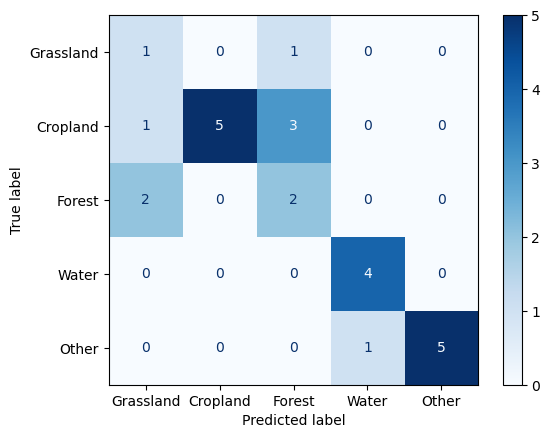

In [13]:
y_true = vali_points['Reference']
y_pred = vali_points['Predicted']
class_names = ['Grassland', 'Cropland', 'Forest', 'Water', 'Other']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, normalize=None, cmap='Blues')

This confusion matrix reports the number of samples labelled as a class in the reference ("True label") and in the prediction, respectively. There would also be options to report ratios instead of counts, i.e. normalize the confusion matrix over the true (rows), predicted (columns) conditions or over all the population. Correctly predicted samples align along the diagonal (starting top-left), off-diagonal samples are misclassified.

For instance, reading along the first column, of four samples predicted as grassland only one is correct (top left corner), one is actually cropland and two are forest (in the manually labelled validation data). Reading along the third row, of four samples actually being forest, two samples were misclassified as grassland and only two were recognized correctly. You will likely get slightly different results, due to randomization in model building and in sampling.<!--Maybe fix this by specifying the random state!?-->

Moreover, scikit-learn provides a convenient function to generate a tabular classification report with the main metrics per class and overall. For details on the metrics and for individually calculating a specific metric see the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) of scikit-learn. 

In [14]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Grassland       0.25      0.50      0.33         2
    Cropland       1.00      0.56      0.71         9
      Forest       0.33      0.50      0.40         4
       Water       0.80      1.00      0.89         4
       Other       1.00      0.83      0.91         6

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.65        25
weighted avg       0.80      0.68      0.71        25



### Disclaimer

Keep in mind that this accuracy assessment demo is based on very few samples ("support" column in the report) and, in practice, we would acquire more validation data. Also remember that during orthophoto interpretation we might have had doubts how to label a validation sample. And last but not least, the classification is based on a simple set of only four features derived from the Sentinel-2 time series, and NDVI was the only spectral index we used.

### Plot an interactive map

Finally, plot a Leaflet map to compare the validation samples and the prediction in spatial context. This may also help to see deficiencies of the classification missed by the random validation samples (there is, e.g., no cropland in the northwestern corner).

In [ ]:
from matplotlib.colors import ListedColormap
import folium
from folium import plugins

# Show the predicted landcover layer (polygonized) in a Folium map object
colormap=ListedColormap(['brown', 'darkgreen', 'lightgreen', 'grey', 'blue'])   # Define a colormap (for alphabetically sorted class names)
m = lc_gdf.explore(column='Landcover', name="Landcover predicted", categorical=True, cmap=colormap)

# Add landcover validation point layer
colormap=ListedColormap(['lightgreen', 'brown', 'darkgreen', 'blue', 'grey'])   # Define a colormap (for class IDs)
vali_points.explore(
    m=m, column="Reference", name="Landcover validation samples",
    marker_kwds={"radius": 4}, style_kwds={"color": "black", "weight": 1},
    categorical=True, legend=False, cmap=colormap
    )

# Add alternative background layer
folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                 attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
                 name='ESRI WorldImagery', control=True).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)          # Add layer control
folium.plugins.Fullscreen().add_to(m)                   # Add a full screen button (for display in a browser)
m                                                       # Show map